# LeNet Architeture

Paper= http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

<img src='assets/lenet.jpeg' width=80% />

In [1]:
import numpy as np 
import torch 
import torch.nn as nn 

In [2]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [6]:
# Check the impage input volume shape 
input_shape = next(iter(train_loader))[0].shape
input_shape

torch.Size([20, 1, 28, 28])

In [17]:
# (W - F + 2P) / S + 1
out_vol = (28 - 5 + 2*2) / 1 + 1

14.0

In [22]:
class LeNet(nn.Module): 
    def __init__(self, in_channels: int = 1, n_classes: int = 10): 
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0))
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)) 
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, n_classes)
      
    def forward(self, x): 
        x = self.relu(self.conv1(x))
        x = self.pool(x) 
        x = self.relu(self.conv2(x))
        x = self.pool(x) 
        x = self.relu(self.conv3(x))
        x = x.view(x.size(0), -1) # batch_size x 120 x 1 x 1 -> 120 x 1
        x = self.relu(self.fc1(x))
        x = self.fc2(x) 
        return x 

model = LeNet()  
model.parameters

<bound method Module.parameters of LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)>

In [23]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [24]:
# number of epochs to train the model
n_epochs = 5

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.555490 	Validation Loss: 0.373231
Validation loss decreased (inf --> 0.373231).  Saving model ...
Epoch: 2 	Training Loss: 0.315517 	Validation Loss: 0.209035
Validation loss decreased (0.373231 --> 0.209035).  Saving model ...
Epoch: 3 	Training Loss: 0.203667 	Validation Loss: 0.163589
Validation loss decreased (0.209035 --> 0.163589).  Saving model ...
Epoch: 4 	Training Loss: 0.151480 	Validation Loss: 0.126568
Validation loss decreased (0.163589 --> 0.126568).  Saving model ...
Epoch: 5 	Training Loss: 0.121621 	Validation Loss: 0.109650
Validation loss decreased (0.126568 --> 0.109650).  Saving model ...


In [25]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [26]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.102441

Test Accuracy of     0: 98% (968/980)
Test Accuracy of     1: 98% (1117/1135)
Test Accuracy of     2: 97% (1008/1032)
Test Accuracy of     3: 96% (976/1010)
Test Accuracy of     4: 93% (921/982)
Test Accuracy of     5: 96% (858/892)
Test Accuracy of     6: 96% (921/958)
Test Accuracy of     7: 97% (1001/1028)
Test Accuracy of     8: 95% (929/974)
Test Accuracy of     9: 95% (967/1009)

Test Accuracy (Overall): 96% (9666/10000)


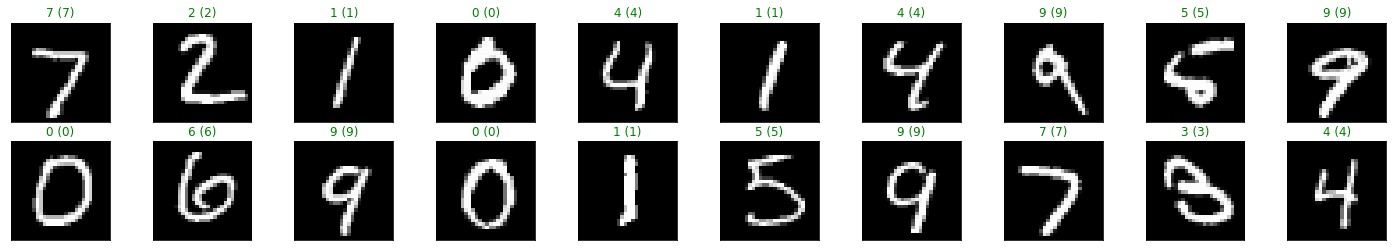

In [29]:
import matplotlib.pyplot as plt 

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))